### The input is a file with format: timestamp, personId, x, y
#### Change randomized so that the id's change also

#### make correlated groups of people

 


In [1]:
import numpy as np
init_timestamp = 1436047260000
beta = (60/55)*60*1000 # in ms, according to the paper Freudiger 2015, mean time delay between packets
sigma_est = 3
half_dist_teleport =10
sigma_teleport = 3
measurement_delay = 1000 # in ms
randomized_probability = 0.15
path_original_positions = "F:/Arena_sim_data/original_positions_size_"
path_fake_positions = "F:/Arena_sim_data/fake_positions_size_"

In [2]:
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [3]:
next_moment = generate_first_moment_visible(3)
next_moment

[1436047272415, 1436047278113, 1436047385964]

In [4]:
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)+1# avoid 0
    return int(timestamp_now + delay)

In [5]:
next_mom = gen_next_moment(3)

In [6]:
next_mom

145719

In [7]:
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(sigma_est)
    sigma_y =  np.random.exponential(sigma_est)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]#in the real data for z is 1000
    new_record["value"]["trackeeHistory"]={}
    new_record["value"]["trackeeHistory"]["localMac"] = randomized
    return new_record

In [8]:
b = make_new_record([0,1,3,4], [5,6], 0)

In [9]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [2.398509801309546, 8.804607273031001, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [10]:
def generate_randomized(crowd_size):
    randomized = [0 for i in range(0, crowd_size)]
    for i in range(0, crowd_size):
        r = np.random.rand()
        if r < randomized_probability:
            randomized[i] = 1
    return randomized

In [11]:
randomized = generate_randomized(10)

In [12]:
randomized


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [14]:
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [15]:
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]
        if next_moment[person] > timestamp-measurement_delay and next_moment[person] <= timestamp:#timestamp
                new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
                fake_record = make_new_record(record, new_position, randomized[person])
                fake_positions.append(fake_record)                
                next_moment[person] = gen_next_moment(next_moment[person])
    return fake_positions            

In [16]:

def get_max_velocity(crowd_density):#by Weidmann's equation
    rho = crowd_density+0.00001 #avoid division by 0
    v_0=1.34 #speed at 0 density
    gamma = 1.913 #fit parameter
    rho_max = 5.4 #at this density movement is not possible
    v =v_0*(1-np.exp(-gamma*(1/rho-1/rho_max)))
    v = max(0, v)
    return v

In [17]:
def gen_rand_mode():
    rand_mode = np.random.rand() 
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    return rand_mode

In [18]:
from scipy.stats import norm
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    i = 0
    dt = measurement_delay/1000#from ms to s
    density = crowd_size/(width_stadium*length_stadium)#should be the local ideally
    velocity = get_max_velocity(density)
    delta =velocity*dt  #for the brownian motion, how many meters per dt:    
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(0, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            #new_x = old_x + norm.rvs(scale=delta**2*dt)
            #new_y = old_y + norm.rvs(scale=delta**2*dt)
            rand_mode = gen_rand_mode()
            new_x = old_x + delta*rand_mode    
            rand_mode = gen_rand_mode()            
            new_y = old_y + delta*rand_mode
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [19]:
import json

def write_fake_positions(positions,filename):
    file = open(filename, 'w')
    file.close()
    with open(filename, 'a') as outfile:
        for record in positions:
            json.dump(record, outfile)  
            outfile.write("\n")
        

In [20]:
import pickle

def write_original_positions(positions, filepath):   
    with open(filepath, 'wb') as fp:
        pickle.dump(positions, fp)

In [21]:

def read_original_positions( filepath):   
    with open(filepath, 'rb') as fp:
        positions = pickle.load(fp)
    return positions    

In [22]:
def makedata(crowd_size, step, howmany):
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions(init_timestamp, crowd_size, 300*1000 , 105, 68)#300 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")        

In [23]:
#makedata(0, 5000, 15)

In [24]:
#fake_positions = make_fake_data(crowd_size, positions)

In [25]:
#fake_positions

In [26]:
np.random.rand()

0.8250772644385223

In [27]:
#positions =  create_positions(10, 2, 105, 68)

In [28]:
#print(positions)

In [29]:
def create_teleportation_effect(positions, modes_distance, sigma):
    for record in positions:
        record[2] = draw_new_coordinate(record[2], modes_distance, sigma)
        record[3] = draw_new_coordinate(record[3], modes_distance, sigma)
    return positions    

In [30]:
#positions = create_teleportation_effect(positions, 10, 5)
#print(positions)

In [31]:
def get_a_snapshot(positions,  timestamp, interval):
    if interval==0:
        snapshot = []        
        for position in positions:
            if position[0] == timestamp:
                snapshot.append(position)            
    else:
        snapshot = []        
        counted = {}
        for position in positions:
            if position[0] >= timestamp and position[0] < timestamp + interval*1000:
                if position[1] not in counted:
                    snapshot.append(position)
                    counted[position[1]] = True
    return snapshot        

In [32]:
#get_a_snapshot(positions, 0)

In [33]:
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_center - half_width_x and record[2] < x_center + half_width_x:
            if record[3] > y_center - half_length_y and record[3] < y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [34]:
import pickle
def read_original_positions(filepath):
    return pickle.load(open( filepath, "rb" ))

In [35]:
def read_fake_positions(filepath):
    data = []
    with open(filepath) as f:
        data = f.readlines()
    fake_positions = []
    for line in data:
        jsline = json.loads(line)
        fake_positions.append([jsline["measurementTimestamp"], jsline["value"]["sourceMac"], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][0], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][1]])
    return fake_positions

In [36]:
#fake_positions = read_fake_positions(filepath)

In [37]:
def get_method_crowd_count(crowd_size, cell_x, cell_y, timeperiod):
    filepath = "F:/Arena_sim_data/output/size_"+ str(crowd_size) + "_" 
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    return z_data[cell_x][cell_y]
    

In [38]:
b = get_method_crowd_count(10000, 6, 6, 8)

In [39]:
b

30.211094383337674

In [58]:
def run( width_stadium, length_stadium, square_half_size, window, stride, crowd_size, step, iterations):
    errors = []
    differences = []
    scatter = []
    scatter_method = []
    #crowd_size = 0
    #step = 5000
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    for i in range (0, iterations):
        crowd_size +=step
        print(i)
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)        
        center_x = 32.5 - width_stadium/2.0
        center_y = 32.5 - length_stadium/2.0
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, square_half_size, square_half_size, 0) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        #print(fake_positions[0])
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, square_half_size, square_half_size, 60)
        new_proportion = fake_crowd_count/crowd_size
        diff= new_proportion-original_proportion
        differences.append(diff)
        error= fake_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.0001)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
        fake_positions = []
        method_crowd_count = 1.176*get_method_crowd_count(crowd_size, 6, 6, window)
        method_error = method_crowd_count - original_crowd_count
        method_relative_error = method_error/(original_crowd_count+0.0001)
        scatter_method.append([original_crowd_count, method_relative_error ])    
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [errors, differences, scatter, scatter_method,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [57]:
makedata(0, 200, 20 )

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000


In [59]:
lists_small = run( 105.0, 68.0, 2.5, 8, 30, 0, 200, 20)

0
200
Original crowd count:1
Fake crowd count:0
Method crowd count:0.743305268785
1
400
Original crowd count:0
Fake crowd count:1
Method crowd count:0.899367441532
2
600
Original crowd count:6
Fake crowd count:1
Method crowd count:1.83363947419
3
800
Original crowd count:3
Fake crowd count:2
Method crowd count:3.45200223615
4
1000
Original crowd count:4
Fake crowd count:4
Method crowd count:2.07345351735
5
1200
Original crowd count:6
Fake crowd count:1
Method crowd count:3.53429196173
6
1400
Original crowd count:1
Fake crowd count:2
Method crowd count:3.59552757381
7
1600
Original crowd count:4
Fake crowd count:1
Method crowd count:5.74675488622
8
1800
Original crowd count:1
Fake crowd count:3
Method crowd count:3.94957065422
9
2000
Original crowd count:4
Fake crowd count:3
Method crowd count:6.14624227778
10
2200
Original crowd count:8
Fake crowd count:1
Method crowd count:8.09511008783
11
2400
Original crowd count:11
Fake crowd count:4
Method crowd count:5.72703515248
12
2600
Origina

In [42]:
lists = run( 105.0, 68.0, 2.5, 8, 30)

0
5000
Original crowd count:24
Fake crowd count:10
Method crowd count:15.0325764757
1
10000
Original crowd count:39
Fake crowd count:18
Method crowd count:29.0214654637
2
15000
Original crowd count:62
Fake crowd count:26
Method crowd count:54.7194472001
3
20000
Original crowd count:69
Fake crowd count:42
Method crowd count:64.2353782864
4
25000
Original crowd count:97
Fake crowd count:81
Method crowd count:88.97013567
5
30000
Original crowd count:112
Fake crowd count:60
Method crowd count:105.794585186
6
35000
Original crowd count:134
Fake crowd count:73
Method crowd count:128.694360668
7
40000
Original crowd count:140
Fake crowd count:74
Method crowd count:126.682746751
8
45000
Original crowd count:181
Fake crowd count:104
Method crowd count:158.073834163
9
50000
Original crowd count:157
Fake crowd count:97
Method crowd count:175.465905156
10
55000
Original crowd count:159
Fake crowd count:126
Method crowd count:184.436669712
11
60000
Original crowd count:228
Fake crowd count:100
Meth

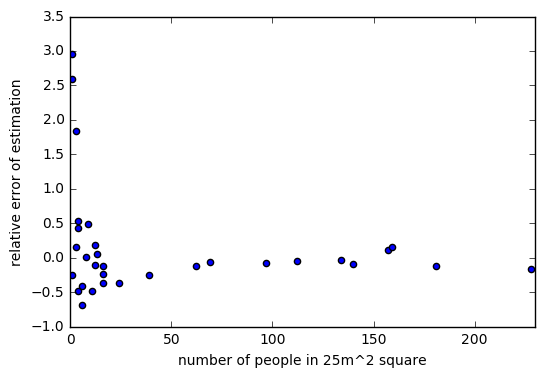

In [64]:

#n = 50
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

x_small = np.array([r[0] for r in lists_small[3] ])
y_small = np.array([r[1] for r in lists_small[3] ])
x = np.array([r[0] for r in lists[3] ])
y = np.array([r[1] for r in lists[3] ])

x= np.concatenate((x_small, x))
y= np.concatenate((y_small, y))

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


#plt.plot(x, 0, color='red')
plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('relative error of estimation')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 230])
axes.set_ylim([-1, 3.5])
plt.show()

In [ ]:
lists[3] 

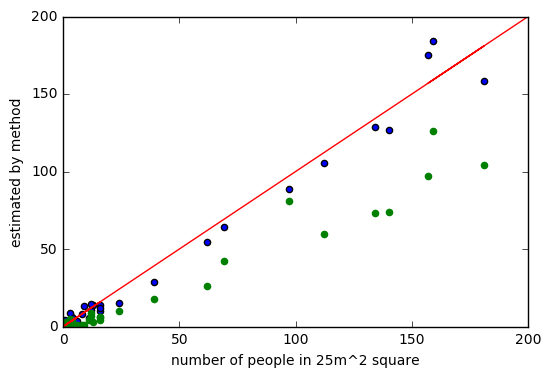

In [66]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[6] ])

x_small = np.array([r for r in lists_small[4] ])
y_small = np.array([r for r in lists_small[6] ])

x= np.concatenate((x_small, x))
y= np.concatenate((y_small, y))

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


#plt.plot(x, fit[0] * x + fit[1], color='red')
plt.plot(x,  x , color='red')
#plt.plot(0, color='red')
plt.scatter(x, y)


x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[5] ])
x_small = np.array([r for r in lists_small[4] ])
y_small = np.array([r for r in lists_small[5] ])

x= np.concatenate((x_small, x))
y= np.concatenate((y_small, y))

plt.scatter(x, y, color = 'green')

plt.ylabel('estimated by method')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([0, 200])
axes.set_ylim([0,200])
plt.show()

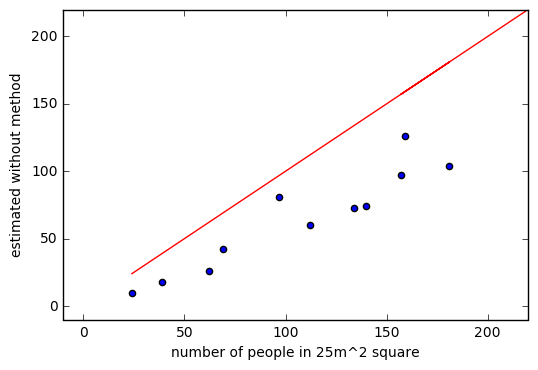

In [54]:
x = np.array([r for r in lists[4] ])
y = np.array([r for r in lists[5] ])

#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()

plt.plot(x,  x , color='red')
#plt.plot(x, fit[0] * x + fit[1], color='red')
#plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('estimated without method')
plt.xlabel('number of people in 25m^2 square')
axes = plt.gca()
axes.set_xlim([-10, 220])
axes.set_ylim([-10,220])
plt.show()

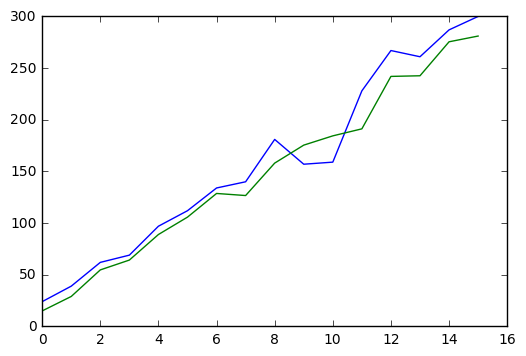

In [52]:
import matplotlib.pyplot as plt
plt.plot(lists[4])
plt.plot(lists[6])

plt.ylabel('')
#plt.xlabel('crowd size (unit:500)')
plt.show()

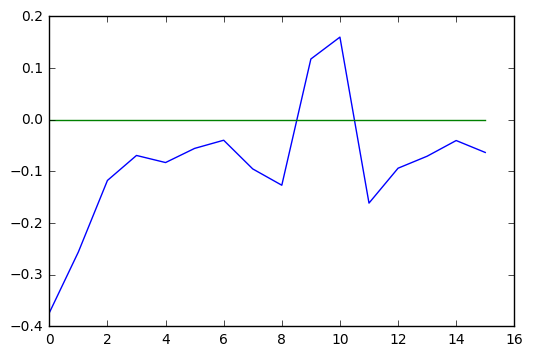

In [49]:
y = np.array([r[1] for r in lists[3] ])
z= np.array([0 for r in lists[3] ])
plt.plot(y)
plt.plot(z)
plt.show()

## Fingerprinting data

In [255]:
def make_fingerprint_data(positions):
    json = {}
    timestamp = 0   
    fing_positions = []
    for record in positions: #record = [timestamp, personId, x, y]          
        fing_record = make_new_record(record, [record[2], record[3]], 0)
        #if positions.shape[1] > 4:
        fing_record["value"]["averagecoordinate"]["error"]["coordinates"] = [0.01, 0.01, 1000.0]
        fing_positions.append(fing_record)                               
    return fing_positions            

In [243]:
positions = read_original_positions("F:/ArenaData/Fingerprinting/positions_fitted.pkl")

In [244]:
positions

array([[  1.37171373e+12,   2.30000000e+01,   7.10370578e+01,
          2.36096948e+02,   1.98742911e+01],
       [  1.37171369e+12,   2.30000000e+01,   6.21555255e+01,
          2.21119733e+02,   1.34999880e+01],
       [  1.37171410e+12,   2.30000000e+01,   7.28260394e+01,
          2.41652014e+02,   1.16379879e+01],
       ..., 
       [  1.37171092e+12,   1.00000000e+01,   9.22491810e+01,
          1.88014670e+02,   9.17984203e+00],
       [  1.37171105e+12,   1.00000000e+01,   6.22446658e+01,
          2.00029762e+02,   4.27608609e+00],
       [  1.37171102e+12,   1.00000000e+01,   5.51128449e+01,
          2.03767866e+02,   1.05344373e+01]])

In [245]:
data = make_fingerprint_data(positions) 

In [246]:
data

[{'measurementTimestamp': 1371713733000.0,
  'value': {'averagecoordinate': {'avg': {'coordinates': [71.037057824439216,
      236.09694801922888,
      0.0]},
    'error': {'coordinates': [0.01, 0.01, 1000.0]}},
   'sourceMac': 23.0,
   'trackeeHistory': {'localMac': 0}}},
 {'measurementTimestamp': 1371713691000.0,
  'value': {'averagecoordinate': {'avg': {'coordinates': [62.155525536804817,
      221.1197326136753,
      0.0]},
    'error': {'coordinates': [0.01, 0.01, 1000.0]}},
   'sourceMac': 23.0,
   'trackeeHistory': {'localMac': 0}}},
 {'measurementTimestamp': 1371714095000.0,
  'value': {'averagecoordinate': {'avg': {'coordinates': [72.826039363318159,
      241.65201431512833,
      0.0]},
    'error': {'coordinates': [0.01, 0.01, 1000.0]}},
   'sourceMac': 23.0,
   'trackeeHistory': {'localMac': 0}}},
 {'measurementTimestamp': 1371713807000.0,
  'value': {'averagecoordinate': {'avg': {'coordinates': [72.699536317196362,
      238.5346542680636,
      0.0]},
    'error': {'co

In [247]:
write_fake_positions(data,"F:/ArenaData/Fingerprinting/fingerprints_fitted.json")

## After the method application

In [218]:
import numpy as np
init_timestamp = 1369908924*1000 + 1804000*1000
measurement_delay = 1000 # in ms
path_original_positions = "F:/ArenaData/Fingerprinting/"
path_fake_positions = "F:/ArenaData/Fingerprinting/"

In [220]:
def get_crowd_count_in_square_fing(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    #print("snapshot length" + str(len(snapshot)))
    for record in snapshot:
        if record[2] > x_min and record[2] < x_max:
            if record[3] > y_min and record[3] < y_max:
                #if abs(record[2] - record[3]) <= belt:
                crowd_count +=1
    return crowd_count
    

In [233]:
def get_all_cells(xmin_cell, xmax_cell, ymin_cell, ymax_cell, timeperiod):
    total =0
    for cell_x in range (int(xmin_cell), int(xmax_cell)):
        for cell_y in range (int(ymin_cell), int(ymax_cell)):
            total += get_method_crowd_count_fing(cell_x, cell_y, timeperiod)
    return total        

In [222]:
def get_method_crowd_count_fing(cell_x, cell_y, timeperiod):
    filepath = "F:/Arena_sim_data/output/fingerprinted_method"
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    return z_data[cell_x][cell_y]

In [252]:
def run_fing( width_stadium, length_stadium,  windows, stride):
    errors = []
    differences = []
    scatter = []
    scatter_method = []
    #crowd_size = 0
    #step = 5000
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    positions = read_original_positions(path_original_positions + "positions.pkl")    
    fake_positions = read_fake_positions(path_fake_positions  + "fingerprints_fitted.json")
    for window in range (0, windows):
        print(window)
        #positions = read_original_positions(path_original_positions + "positions.pkl")    
        #print(positions[0])
        original_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, positions, x_min, x_max, y_min, y_max, belt, 60) 
        if original_crowd_count > 0:
            print("original crowd count = " + str(original_crowd_count))
        #original_proportion = original_crowd_count/crowd_size
        #positions = []
        #fake_positions = read_fake_positions(path_fake_positions  + "fingerprints_fitted.json")
        #print(fake_positions[0])
        fake_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, fake_positions, x_min, x_max, y_min, y_max, belt, 60)
        #new_proportion = fake_crowd_count/crowd_size
        #diff= new_proportion-original_proportion
        #differences.append(diff)
        error= fake_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.0001)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
        #fake_positions = []
        method_crowd_count = get_all_cells(xmin_cell, xmax_cell, ymin_cell, ymax_cell, window)
        method_error = method_crowd_count - original_crowd_count
        method_relative_error = method_error/(original_crowd_count+0.0001)
        scatter_method.append([original_crowd_count, method_relative_error ])    
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [errors, differences, scatter, scatter_method,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [258]:
start_x = -7600
start_y = 4864700
x_min = -7415 - start_x
x_max = -7300 - start_x
y_min = 90 
y_max = 165 
belt = 35
cellsize = 5
x_min, x_max, y_min, y_max = 0,300, 0, 300
#xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize
xmin_cell, xmax_cell, ymin_cell, ymax_cell = 0, 60,0,60

In [256]:
x_min

185

In [213]:
x_min/5

37.0

In [214]:
x_max/5

60.0

In [215]:
y_min/5

18.0

In [216]:
y_max/5

33.0

In [259]:
lists = run_fing( 300, 300, 432 ,30)

0
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
1
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
2
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
3
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
4
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
5
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
6
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
7
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
8
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
9
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
10
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
11
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
12
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
13
Original crowd count:0
Fake crowd count:0
Method crowd count:0.0
14
Original crowd count:0
Fake crowd count:0
Method crowd 

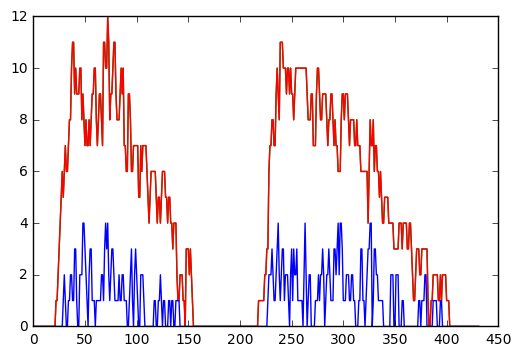

In [260]:
import matplotlib.pyplot as plt
plt.plot(lists[4],  color = "green" )
plt.plot(lists[5], color = "red")
plt.plot(lists[6], color = "blue")

plt.ylabel('')
#plt.xlabel('crowd size (unit:500)')
plt.show()